In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = torch.device('cuda')

from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
clear_output()

import utils
import data_extraction as da
import extract_sem_representation as esr

import modelling as md
import plotting

test_size = 0.1
# TODO: create graph showing experiments with pooling strategies

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eye4got/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
cat_cols = ['themes', 'violence', 'drug_use', 'sex']

df = pd.read_parquet(da.cleaned_dataset_fp).drop(columns=['nudity', 'language']).sort_values(['movie', 'start_time'])

for col in cat_cols:
    df[col] = md.convert_col_to_ordinal(df[col])
    
ratings = df[cat_cols + ['movie']].drop_duplicates().drop(columns=['movie']).values

In [13]:
preds = []

for pooling_model_name in md.pooling_models:
    for rep_type in ('chunks', 'utterances'):
        for only_dialogue in [True, False]:
            X_train, X_test, y_train, y_test = esr.get_dataset_split(pooling_model_name, only_dialogue, rep_type, ratings, test_size)

            basic_log_model = MultiOutputClassifier(LogisticRegression(max_iter=10000))
            basic_log_model.fit(X_train, y_train)
            y_pred = basic_log_model.predict(X_test)
            preds.append({'model': pooling_model_name, 'rep_type': rep_type, 'only_dialogue': only_dialogue, 'preds': y_pred})
            
clear_output()

In [20]:
preds_metrics = [{key: value for key, value in row_dict.items()} for row_dict in preds]

for row in preds_metrics:
    row['acc'] = accuracy_score(y_test.reshape(-1), row['preds'].reshape(-1))
    row['f1_macro'] = f1_score(y_test.reshape(-1), row['preds'].reshape(-1), average='macro')
    del row['preds']

In [45]:
preds_metrics_df = pd.DataFrame(preds_metrics)
models_masks = [preds_metrics_df['model'].eq(name) for name in md.pooling_models]

preds_metrics_df['abb_model_name'] = np.select(
    models_masks,
    ['cardiff-multilabel', 'cardiff-binary', 'cardif-sentiment', 'emotions', 'imdb-sentiment'],
    default='Error'
)
preds_metrics_df['cat'] = 'Packing: ' + preds_metrics_df['rep_type'] + ', Incl. Transcript: ' + preds_metrics_df['only_dialogue'].eq(False).astype(str)

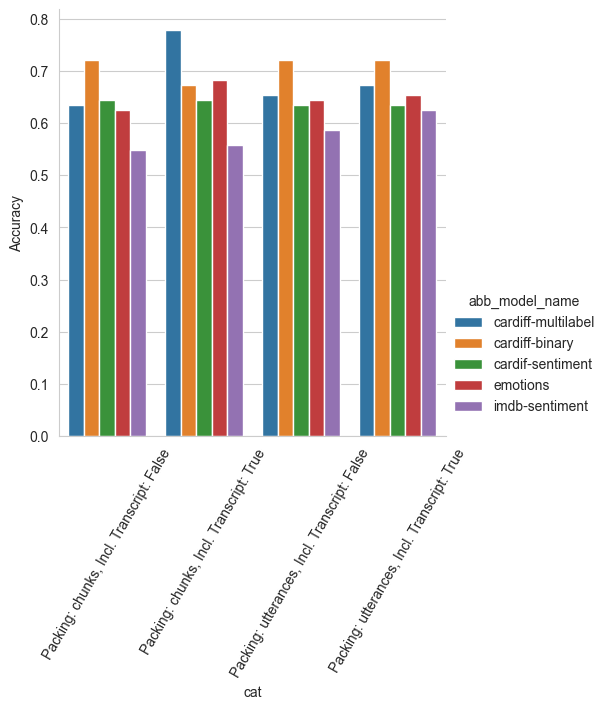

In [76]:
g = sns.catplot(
    data=preds_metrics_df, kind='bar',
    x='cat', y='acc', hue='abb_model_name',
)
plt.ylabel('Accuracy')
g.set_xticklabels(rotation=60)
plt.show()

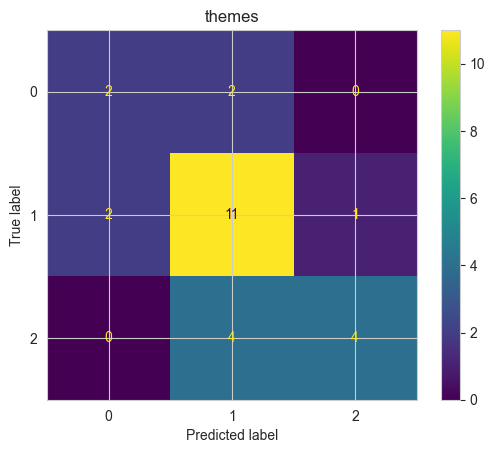

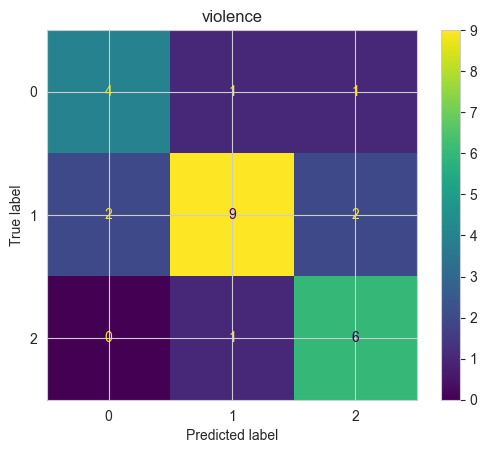

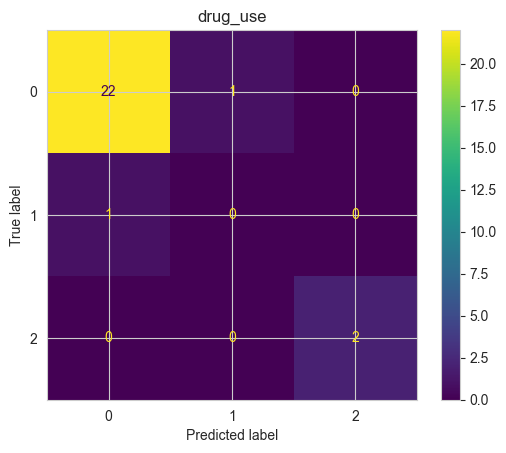

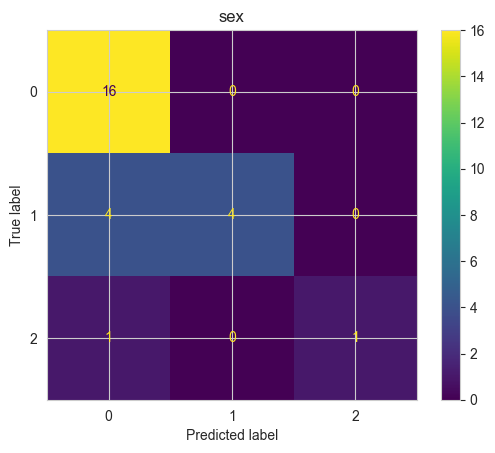

In [75]:
for ii, col in enumerate(md.cat_cols):
    curr_cat_preds = preds[1]['preds'][:, ii]
    curr_cat_true = y_test[:, ii]
    mat = confusion_matrix(curr_cat_true, curr_cat_preds)
    disp = ConfusionMatrixDisplay(mat)
    disp.plot()
    plt.title(col)
    plt.show()